In [1]:
install.packages("/work/pi_sarah_gignouxwolfsohn_uml_edu/caroline/BEL_16S_outputs/ggupset-0.4.1.tar.gz", repos = NULL, type = "source")

In [74]:
require(data.table)
require(tidyverse)
require(phyloseq)
require(genefilter)
require(UpSetR)
require(ggplot2)
require(vegan)
require(RColorBrewer)
library("ggupset")

In [75]:
ps<-readRDS(file = "/work/pi_sarah_gignouxwolfsohn_uml_edu/caroline/RDS/ps.rds")

In [76]:
head(sample_data(ps))

,Health_Status,colony,Date_16S,double_band,transect,species,MonthYear,Condition,GTTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCGTGTAGGCGGAACGATCAGTCGGAGGTGAAATCCCGGGGCTTAACCCCGGAACTGCCTTCGATACTATCGTTCTAGAGATCGGAAGAGGTGAGTGGAATTCCCAGTGTAGAGGTGGAATTCGTAGATATTGGGAAGAACACCAGAGGCGAAGGCGACTCACTGGTCCGATACTGACGCTCAGACGCGAAAGTGTGGGG,GCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCATGCAGGTGGTTTGTTAAGTCAGATGTGAAAGCCCGGGGCTCAACCTCGGAATAGCATTTGAAACTGGCAGACTAGAGTACTGTAGAGGGGGGTAGAATTTCAGGTGTAGCGGTGAAATGCGTAGAGATCTGAAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAGATACTGACACTCAGATGCGAAAGCGTGGGG,⋯,CAGCCGCGGTAATACGGAGGGGGTTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCGTGTAGGCGGAACGATCAGTCGGAGGTGAAATCCCGGGGCTTAACCCCGGAACTGCCTTCGATACTATCGTTCTAGAGATCGGAAGAGGTGAGTGGAATTCCCAGTGTAGAGGTGGAATTCGTAGATATTGGGAAGAACACCGGAGGCGAAGGCGACTCACTGGT,TTTGTTTTTTAGAAAAAGCAGAAAGCGTGTAAAGGGCGTGCAGGCGGACCGATAAGTCGTCTGTGAAATCTGTCGGCTCAACCAACAACTTGCAGTCGAAACTATCGGTCTTGAGTACAGGAGAGGAGAGCGGAATCTCAGGTGTAGCGGTGAAATGCGTAGATATCTGGGAGAACACCGGTGGCGAAGGCGGCTCTCTGGAAGGATACTGACGCTGAGGCGCGAAAGCTAGGGG,ACTTTTTAAGTCTACTGTTAAAGAATAAGACTTAACCTTAAAAAAGCGGTATGAAACTGAAAAGCTTGAGTTTAGTAGGGGTAGAGGGAATTCTCGGTGTAGTGGTGAAATGCGTAGAGATCGAGAAGAACACCGGTAGCGAAGGCGCTCTGCTGGGCTAAAACTGACACTGAGAGACGAAAGCTAGGGGAGCAAATAGGATTAGAAACCCTAGTAGTCCGACTGTCTCTT,GCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCACGCAGGCGGTTTGTTAAGCTAGATGTGAAAGCCCCGGGCTCAACCTGGGATGGTCATTTAGAACTGGCAGACTAGAGTCTTGGAGAGGGGAGTGGAATTCCAGGTGTAGCGGTGAAATGCGTAGATATCTGGAGGAACATCAGTGGCGAAGGCGACTCCCTGGAAAAAGACTGACGCTCATGTGCGAAAGTGTGGGT,input,filtered,denoisedF,denoisedR,merged,nonchim
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>,<chr>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
012024_BEL_CBC_T1_557_SSID,Healthy,1_3,3_4_2025,y,T1,SSID,Jan 2024,Healthy,43,578,⋯,0,0,0,0,140907,132539,130818,130771,127036,118800
012024_BEL_CBC_T1_563_PSTR,Healthy,1_12,3_6_2025,,T1,PSTR,Jan 2024,Healthy,0,151,⋯,0,0,0,0,97665,89798,89392,89308,88670,48116
012024_BEL_CBC_T2_601_OFAV,Healthy,2_79,3_4_2025,,T2,OFAV,Jan 2024,Healthy,7,277,⋯,0,0,0,0,263467,250569,249704,249707,248016,191585
012024_BEL_CBC_T2_605_SSID,Healthy,2_99,3_10_2025,y,T2,SSID,Jan 2024,CLB,38,434,⋯,0,0,0,0,605361,574264,571735,571551,564520,517961
012024_BEL_CBC_T3_627_PAST,Healthy,3_34,3_10_2025,y,T3,PAST,Jan 2024,Healthy,0,872,⋯,0,0,0,0,1656969,1561240,1540358,1539923,1487115,1323604
012024_BEL_CBC_T3_631_MCAV,Healthy,3_21,3_4_2025,,T3,MCAV,Jan 2024,Healthy,45,331,⋯,0,0,0,0,513353,484960,483847,483931,476841,424109


In [77]:
ps <- prune_taxa(taxa_sums(ps) > 0, ps)

In [78]:
#isolate just bacteria
ps_norm_bac=subset_taxa(ps, Kingdom=="Bacteria")
ps_norm_bac
#remove chloroplast order and mitchondria family
ps_norm_nochlo=subset_taxa(ps_norm_bac, Order!="Chloroplast")
ps_clean=subset_taxa(ps_norm_nochlo, Family!="Mitochondria")

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 103479 taxa and 92 samples ]
sample_data() Sample Data:       [ 92 samples by 107891 sample variables ]
tax_table()   Taxonomy Table:    [ 103479 taxa by 6 taxonomic ranks ]

## new df for all sampled in each species based on ps_clean

In [7]:
#new dataframes for each species 
ps_mcav <- subset_samples(ps_clean, species == "MCAV")
ps_pstr <- subset_samples(ps_clean, species == "PSTR")
ps_ofav <- subset_samples(ps_clean, species == "OFAV")
ps_ssid <- subset_samples(ps_clean, species == "SSID")
ps_oann <- subset_samples(ps_clean, species == "OANN")
ps_past <- subset_samples(ps_clean, species == "PAST") 

In [8]:
#should add up to 57 samples bc not isolating samples with repeated colonies
nrow(sample_data(ps_mcav))
nrow(sample_data(ps_pstr))
nrow(sample_data(ps_ofav))
nrow(sample_data(ps_oann))
nrow(sample_data(ps_ssid))
nrow(sample_data(ps_past))

[1] 26

[1] 16

[1] 16

[1] 4

[1] 12

[1] 18

# Gene filter core microbiome

## what are the most abundant otus across corals?

- they are endozoicomonas

In [9]:
#kOverA assumes taxa are rows, so need to transpose
ps_clean_t <- ps_clean
otu_table(ps_clean_t) <- t(otu_table(ps_clean))
taxa_are_rows(ps_clean_t)

[1] TRUE

### there are NO otu's shared among every sample

In [10]:
#how many samples each otu is present in
otu <- as(otu_table(ps_clean_t), "matrix")
prev <- rowSums(otu > 0)

summary(prev)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   1.000   2.752   2.000  89.000 

In [11]:
sum(otu == 0)

[1] 4196386

### how many taxa shared across 89 samples?
### and what are the 3 odd samples out??

In [11]:
flist <- filterfun(kOverA(89, 0))
all <- filter_taxa(ps_clean_t, flist, prune = TRUE)
tax_table(all)

,Kingdom,Phylum,Class,Order,Family,Genus
GCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGTAGGCGGCCTTTTAAGTTGGATGTGAAAGCCCCGGGCTTAACCTGGGAACGGCATCCAAAACTGAGAGGCTCGAGTGCGGAAGAGGAGTGTGGAATTTCCTGTGTAGCGGTGAAATGCGTAGATATAGGAAAGAACACCAGTGGCGAAGGCGACACTCTGGTCTGACACTGACGCTGAGGTACGAAAGCGTGGGG,Bacteria,Pseudomonadota,Gammaproteobacteria,Pseudomonadales,Endozoicomonadaceae,Parendozoicomonas


## reduce the size of the pool based on meta data:
## each coral species

In [12]:
class(ps_clean_t)

[1] "phyloseq"
attr(,"package")
[1] "phyloseq"

In [13]:
#otu is already a matrix based on ps_t
meta <- sample_data(ps_clean_t)

In [14]:
#what otus present in every MCAV?
mcav_flist= filterfun(kOverA(26, 0))
mcav=phyloseq::filter_taxa(ps_mcav, mcav_flist, TRUE )
tax_table(mcav)

,Kingdom,Phylum,Class,Order,Family,Genus
GCAAGCGTTGTTCGGATTTACTGGGCGTAAAGGGTGCGTAGGTGGCATGACAAGTCACTTGTGAAATCTCCGAGCTTAACTCGGAACGGTCAAGTGATACTGTTGTGCTAGAGTGCGGGAAGGGCAGCTGGAATTCTTGGTGTAGCGGTGAAATGCGTAGATATCAAGAGGAACACCGGAGGCGAAGGCGAGTTGCTAGACCGACACTGACGCTGAGGCACGAAAGCCAGGGG,Bacteria,Acidobacteriota,Blastocatellia,Blastocatellales,Blastocatellaceae,NA
GCTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCACGTAGGCGGCTTTGTAAGTTAGAGGTGAAAGCCTGGAGCTTAACTCCAGAATTGCCTTTAAGACTGCATCGCTTGAATCCGGGAGAGGTGAGTGGAATTCCGAGTGTAGAGGTGAAATTCGTAGATATTCGGAAGAACACCAGTGGCGAAGGCGGCTCACTGGACCGGTATTGACGCTGAGGTGCGAAAGCGTGGGG,Bacteria,Pseudomonadota,Alphaproteobacteria,Sphingomonadales,Sphingomonadaceae,Hephaestia


In [15]:
#what otus present in every PAST?
past_flist= filterfun(kOverA(18, 0))
past=phyloseq::filter_taxa(ps_past, past_flist, TRUE )
tax_table(past)

,Kingdom,Phylum,Class,Order,Family,Genus
GCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGTAGGCGGCCTTTTAAGTTGGATGTGAAAGCCCCGGGCTTAACCTGGGAACGGCATCCAAAACTGAGAGGCTCGAGTGCGGAAGAGGAGTGTGGAATTTCCTGTGTAGCGGTGAAATGCGTAGATATAGGAAAGAACACCAGTGGCGAAGGCGACACTCTGGTCTGACACTGACGCTGAGGTACGAAAGCGTGGGG,Bacteria,Pseudomonadota,Gammaproteobacteria,Pseudomonadales,Endozoicomonadaceae,Parendozoicomonas
GCAAGCGTTGTCCGGAATTATTGGGTTTAAAGGGTGTGTAGGCGGCTAATTAAGTCAGAGGTGAAATGCTAGAGCTTAACTTTAGAACGGCCTTTGAAACTAGTTAGCTTGAGTCAAGGAGAGGTAGGGAGAATTTATGGTGGAGCGGTGAAATGCATAGATACCATAAGGAATACCGATAGCGAAGGCCCCTTACTGGCCTTTGACTGACGCTGAGACACGAAAGCGTGGGT,Bacteria,Bacteroidota,Bacteroidia,Cytophagales,Amoebophilaceae,NA


In [16]:
#what otus present in every OFAV?
ofav_flist= filterfun(kOverA(16, 0))
ofav=phyloseq::filter_taxa(ps_ofav, ofav_flist, TRUE )
tax_table(ofav)

,Kingdom,Phylum,Class,Order,Family,Genus
GCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCATGCAGGTGGTTTGTTAAGTCAGATGTGAAAGCCCGGGGCTCAACCTCGGAATAGCATTTGAAACTGGCAGACTAGAGTACTGTAGAGGGGGGTAGAATTTCAGGTGTAGCGGTGAAATGCGTAGAGATCTGAAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAGATACTGACACTCAGATGCGAAAGCGTGGGG,Bacteria,Pseudomonadota,Gammaproteobacteria,Enterobacterales,Vibrionaceae,Vibrio
GCAAGCGTTGTTCGGAATTACTGGGCGTAAAGGGCGTGTAGGCGGATTATCAAGTTAGGGGTGAAATCCCGGGGCTCAACCTCGGCACTGCCTTTAAGACTGATAATCTAGAGTATGTGAGGGGATAATGGAATACCTAGTGTAGAGGTGAAATTCGTAGATATTAGGTGGAACACCAGTGGCGAAGGCGATTATCTGGCACATTACTGACGCTGAGGCGCGAAAGCGTGGGG,Bacteria,Pseudomonadota,Alphaproteobacteria,Rhodospirillales,Terasakiellaceae,Marivibrio
TCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCGCGTAGGCGGTTTGCTAAGTCAGATGTGAAATCCCTGGGCTTAACCTAGGAACTGCATTTGAAACTAGCAAGCTAGAGTATGGTAGAGGTGGGTGGAATTTCAGGTGTAGCGGTGGAATGCGTAGAGATCTGAAGGAACATCAGTGGCGAAGGCGGCTCACTGGGCCATCACTGACGCTGAGGTGCGAAAGCGTGGGT,Bacteria,Pseudomonadota,Gammaproteobacteria,Nitrosococcales,Methylophagaceae,Marine Methylotrophic Group 3
GCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCATGCAGGTGGTTTGTTAAGTCAGATGTGAAAGCCCGGGGCTCAACCTCGGAATTGCATTTGAAACTGGCAGACTAGAGTACTGTAGAGGGGGGTAGAATTTCAGGTGTAGCGGTGAAATGCGTAGAGATCTGAAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAGATACTGACACTCAGATGCGAAAGCGTGGGG,Bacteria,Pseudomonadota,Gammaproteobacteria,Enterobacterales,Vibrionaceae,Vibrio
GCAAGCGTTATCCGGATTTACTGGGTTTAAAGAGTGCGTAGGCGGCTTCTTAAGTCAGTGGTGAAAGCTTAGCGCTTAACGCTAGAAGTGCCACTGATACTGGGAAGCTTGAGTCAAGAAGAGGTAAGCAGAATTCATAGTGTAGCAGTGAAATGCTTAGATACTATGAGGAATACCAACAGCGAAGGCAGCTTACTGGTCTTGTACTGACGTTGAGGCACGAAAGCGTGGGT,Bacteria,Bacteroidota,Bacteroidia,Cytophagales,Amoebophilaceae,Candidatus Amoebophilus
GCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCATGCAGGCGGCTTGTTAAGCCAGATGTGAAAGCCCGGGGCTCAACCTCGGAATAGCATTTGGAACTGGCAGGCTAGAGTCTTGTAGAGGGGGGTAGAATTTCAGGTGTAGCGGTGAAATGCGTAGAGATCTGAAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAAAGACTGACGCTCAGATGCGAAAGCGTGGGG,Bacteria,Pseudomonadota,Gammaproteobacteria,Enterobacterales,Vibrionaceae,Photobacterium
GTTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCACGTAGGCGGATCGGAAAGTTGGGGGTGAAATCCCGGGGCTCAACCCCGGAACTGCCTCCAAAACTATCGGTCTAGAGTTCGAGAGAGGTGAGTGGAATTCCGAGTGTAGAGGTGAAATTCGTAGATATTCGGAGGAACACCAGTGGCGAAGGCGGCTCACTGGCTCGATACTGACGCTGAGGTGCGAAAGTGTGGGG,Bacteria,Pseudomonadota,Alphaproteobacteria,Rhodobacterales,Paracoccaceae,Ruegeria
GCAAGCGTTGTCCGGAATTATTGGGTTTAAAGGGTGTGTAGGCGGCTAATTAAGTCAGAGGTGAAATGCTAGAGCTTAACTTTAGAACGGCCTTTGAAACTAGTTAGCTTGAGTCAAGGAGAGGTAGGGAGAATTTATGGTGGAGCGGTGAAATGCATAGATACCATAAGGAATACCGATAGCGAAGGCCCCTTACTGGCCTTTGACTGACGCTGAGACACGAAAGCGTGGGT,Bacteria,Bacteroidota,Bacteroidia,Cytophagales,Amoebophilaceae,NA
GCAAGCGTTATTCGGAATCATTGGGTTTAAAGGGTTCGTAGGCGGATTGGTAAGTCAGGGGTGAAAAGCTGCAGCTTAACTGTAGTCGTGCCTTTGATACTGTCAGTCTTGAGTTATATTGAAGTAAGTAGAATATGTAGTGTAGCGGTGAAATGCTTAGATATTACATAGAATACCGATTGCGAAGGCAGCTTACTAAGTATATACTGACGCTGATGAACGAAAGCGTGGGG,Bacteria,Bacteroidota,Bacteroidia,Flavobacteriales,Flavobacteriaceae,Maritimimonas
GCTAGCGTTGCTCGGAATCACTGGGCGTAAAGGGCGCGTAGGCGGCCGATTAAGTCGGGGGTGAAAGCCTGTGGCTCAACCACAGAATTGCCTTCGATACTGGTTGGCTTGAGACCGGAAGAGGACAGCGGAACTGCGAGTGTAGAGGTGAAATTCGTAGATATTCGCAAGAACACCAGTGGCGAAGGCGGCTGTCTGGTCCGGTTCTGACGCTGAGGCGCGAAAGCGTGGGG,Bacteria,Pseudomonadota,Alphaproteobacteria,Hyphomicrobiales,Beijerinckiaceae,Methylorubrum


### OANNs it actually makes sense that they have a lot in common because there were only 4 samples, and at least two are from the same colony

In [17]:
#what otus present in every OANN?
oann_flist= filterfun(kOverA(4, 0))
oann=phyloseq::filter_taxa(ps_oann, oann_flist, TRUE )
tax_table(oann)

,Kingdom,Phylum,Class,Order,Family,Genus
GCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGTAGGCGGCCTTTTAAGTTGGATGTGAAAGCCCCGGGCTTAACCTGGGAACGGCATCCAAAACTGAGAGGCTCGAGTGCGGAAGAGGAGTGTGGAATTTCCTGTGTAGCGGTGAAATGCGTAGATATAGGAAAGAACACCAGTGGCGAAGGCGACACTCTGGTCTGACACTGACGCTGAGGTACGAAAGCGTGGGG,Bacteria,Pseudomonadota,Gammaproteobacteria,Pseudomonadales,Endozoicomonadaceae,Parendozoicomonas
GCAAGCGTTGTTCGGAATTACTGGGCGTAAAGGGCGTGTAGGCGGATTATCAAGTTAGGGGTGAAATCCCGGGGCTCAACCTCGGCACTGCCTTTAAGACTGATAATCTAGAGTATGTGAGGGGATAATGGAATACCTAGTGTAGAGGTGAAATTCGTAGATATTAGGTGGAACACCAGTGGCGAAGGCGATTATCTGGCACATTACTGACGCTGAGGCGCGAAAGCGTGGGG,Bacteria,Pseudomonadota,Alphaproteobacteria,Rhodospirillales,Terasakiellaceae,Marivibrio
TCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCGCGTAGGCGGTTTGCTAAGTCAGATGTGAAATCCCTGGGCTTAACCTAGGAACTGCATTTGAAACTAGCAAGCTAGAGTATGGTAGAGGTGGGTGGAATTTCAGGTGTAGCGGTGGAATGCGTAGAGATCTGAAGGAACATCAGTGGCGAAGGCGGCTCACTGGGCCATCACTGACGCTGAGGTGCGAAAGCGTGGGT,Bacteria,Pseudomonadota,Gammaproteobacteria,Nitrosococcales,Methylophagaceae,Marine Methylotrophic Group 3
GCAAGCGTTGTTCGGATTTACTGGGCGTAAAGGGTGCGTAGGTGGCATGACAAGTCACTTGTGAAATCTCCGAGCTTAACTCGGAACGGTCAAGTGATACTGTTGTGCTAGAGTGCGGGAAGGGCAGCTGGAATTCTTGGTGTAGCGGTGAAATGCGTAGATATCAAGAGGAACACCGGAGGCGAAGGCGAGTTGCTAGACCGACACTGACGCTGAGGCACGAAAGCCAGGGG,Bacteria,Acidobacteriota,Blastocatellia,Blastocatellales,Blastocatellaceae,NA
GCAAGCGTTATCCGGATTTACTGGGTTTAAAGAGTGCGTAGGCGGCTTCTTAAGTCAGTGGTGAAAGCTTAGCGCTTAACGCTAGAAGTGCCACTGATACTGGGAAGCTTGAGTCAAGAAGAGGTAAGCAGAATTCATAGTGTAGCAGTGAAATGCTTAGATACTATGAGGAATACCAACAGCGAAGGCAGCTTACTGGTCTTGTACTGACGTTGAGGCACGAAAGCGTGGGT,Bacteria,Bacteroidota,Bacteroidia,Cytophagales,Amoebophilaceae,Candidatus Amoebophilus
GCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCACGCAGGCGGTTTGTTAAGCTAGATGTGAAAGCCCCGGGCTCAACCTGGGATGGTCATTTAGAACTGGCAGACTAGAGTCTTGGAGAGGGGAGTGGAATTCCAGGTGTAGCGGTGAAATGCGTAGATATCTGGAGGAACATCAGTGGCGAAGGCGACTCCCTGGCCAAAGACTGACGCTCATGTGCGAAAGTGTGGGT,Bacteria,Pseudomonadota,Gammaproteobacteria,Enterobacterales,Alteromonadaceae,Alteromonas
GCAAGCGTTATCCGGATTTACTGGGTTTAAAGAGTGCGTAGGCGGCTTCTTAAGTCAATGGTGAAAGCTTAGCGCTTAACGCTAGAAGTGCCACTGATACTGGGAAGCTTGAGTCAAGAAGAGGTAAGCAGAATTCATAGTGTAGCAGTGAAATGCTTAGATACTATGAGGAATACCAACAGCGAAGGCAGCTTACTGGTCTTGTACTGACGTTGAGGCACGAAAGCGTGGGT,Bacteria,Bacteroidota,Bacteroidia,Cytophagales,Amoebophilaceae,Candidatus Amoebophilus
GCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCATGCAGGCGGCTTGTTAAGCCAGATGTGAAAGCCCGGGGCTCAACCTCGGAATAGCATTTGGAACTGGCAGGCTAGAGTCTTGTAGAGGGGGGTAGAATTTCAGGTGTAGCGGTGAAATGCGTAGAGATCTGAAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAAAGACTGACGCTCAGATGCGAAAGCGTGGGG,Bacteria,Pseudomonadota,Gammaproteobacteria,Enterobacterales,Vibrionaceae,Photobacterium
GTTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCACGTAGGCGGATCGGAAAGTTGGGGGTGAAATCCCGGGGCTCAACCCCGGAACTGCCTCCAAAACTATCGGTCTAGAGTTCGAGAGAGGTGAGTGGAATTCCGAGTGTAGAGGTGAAATTCGTAGATATTCGGAGGAACACCAGTGGCGAAGGCGGCTCACTGGCTCGATACTGACGCTGAGGTGCGAAAGTGTGGGG,Bacteria,Pseudomonadota,Alphaproteobacteria,Rhodobacterales,Paracoccaceae,Ruegeria
GCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCATGCAGGTGGTTAGTTAAGTCAGATGTGAAAGCCCGGGGCTCAACCTCGGAATTGCATTTGAAACTGGCTGACTAGAGTACTGTAGAGGGGGGTAGAATTTCAGGTGTAGCGGTGAAATGCGTAGAGATCTGAAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAGATACTGACACTCAGATGCGAAAGCGTGGGG,Bacteria,Pseudomonadota,Gammaproteobacteria,Enterobacterales,Vibrionaceae,Vibrio


###  :0 tf? 12 ssid from 4 diff time points actually have a lot in common

In [18]:
#what otus present in every SSID?

flist= filterfun(kOverA(12, 0))
ssid=phyloseq::filter_taxa(ps_ssid, flist, TRUE )
tax_table(ssid)

,Kingdom,Phylum,Class,Order,Family,Genus
GCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCATGCAGGTGGTTTGTTAAGTCAGATGTGAAAGCCCGGGGCTCAACCTCGGAATAGCATTTGAAACTGGCAGACTAGAGTACTGTAGAGGGGGGTAGAATTTCAGGTGTAGCGGTGAAATGCGTAGAGATCTGAAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAGATACTGACACTCAGATGCGAAAGCGTGGGG,Bacteria,Pseudomonadota,Gammaproteobacteria,Enterobacterales,Vibrionaceae,Vibrio
GCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGTAGGCGGCCTTTTAAGTTGGATGTGAAAGCCCCGGGCTTAACCTGGGAACGGCATCCAAAACTGAGAGGCTCGAGTGCGGAAGAGGAGTGTGGAATTTCCTGTGTAGCGGTGAAATGCGTAGATATAGGAAAGAACACCAGTGGCGAAGGCGACACTCTGGTCTGACACTGACGCTGAGGTACGAAAGCGTGGGG,Bacteria,Pseudomonadota,Gammaproteobacteria,Pseudomonadales,Endozoicomonadaceae,Parendozoicomonas
GCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCATGCAGGTGGTTTGTTAAGTCAGATGTGAAAGCCCGGGGCTCAACCTCGGAATTGCATTTGAAACTGGCAGACTAGAGTACTGTAGAGGGGGGTAGAATTTCAGGTGTAGCGGTGAAATGCGTAGAGATCTGAAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAGATACTGACACTCAGATGCGAAAGCGTGGGG,Bacteria,Pseudomonadota,Gammaproteobacteria,Enterobacterales,Vibrionaceae,Vibrio
GCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCATGCAGGCGGCTTGTTAAGCCAGATGTGAAAGCCCGGGGCTCAACCTCGGAATAGCATTTGGAACTGGCAGGCTAGAGTCTTGTAGAGGGGGGTAGAATTTCAGGTGTAGCGGTGAAATGCGTAGAGATCTGAAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAAAGACTGACGCTCAGATGCGAAAGCGTGGGG,Bacteria,Pseudomonadota,Gammaproteobacteria,Enterobacterales,Vibrionaceae,Photobacterium
GTTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCACGTAGGCGGATCGGAAAGTTGGGGGTGAAATCCCGGGGCTCAACCCCGGAACTGCCTCCAAAACTATCGGTCTAGAGTTCGAGAGAGGTGAGTGGAATTCCGAGTGTAGAGGTGAAATTCGTAGATATTCGGAGGAACACCAGTGGCGAAGGCGGCTCACTGGCTCGATACTGACGCTGAGGTGCGAAAGTGTGGGG,Bacteria,Pseudomonadota,Alphaproteobacteria,Rhodobacterales,Paracoccaceae,Ruegeria
GCTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCACGTAGGCGGCTTTGTAAGTTAGAGGTGAAAGCCTGGAGCTTAACTCCAGAATTGCCTTTAAGACTGCATCGCTTGAATCCGGGAGAGGTGAGTGGAATTCCGAGTGTAGAGGTGAAATTCGTAGATATTCGGAAGAACACCAGTGGCGAAGGCGGCTCACTGGACCGGTATTGACGCTGAGGTGCGAAAGCGTGGGG,Bacteria,Pseudomonadota,Alphaproteobacteria,Sphingomonadales,Sphingomonadaceae,Hephaestia
GCAAGCGTTATCCGGAATTATTGGGCGTAAAGCGTCCGCAGGCGGCCCTTCAAGTCTGCTGTTAAAAAGTGGAGCTTAACTCCATCATGGCAGTGGAAACTGTTGGGCTTGAGTGTGGTAGGGGCAGAGGGAATTCCCGGTGTAGCGGTGAAATGCGTAGATATCGGGAAGAACACCAGTGGCGAAGGCGCTCTGCTGGGCCATCACTGACGCTCATGGACGAAAGCCAGGGG,Bacteria,Cyanobacteriota,Cyanobacteriia,Synechococcales,Cyanobiaceae,Synechococcus CC9902
GCTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCACGTAGGCGGACTTTTAAGTCAGATGTGAAATCCCGAGGCTCAACCTCGGAACTGCATTTGAAACTGGGAGTCTAGAGATCAGGAGAGGTTAGCGGAATACCGAGTGTAGAGGTGAAATTCGTAGATATTCGGTGGAACACCAGTGGCGAAGGCGGCTAACTGGACTGATACTGACGCTGAGGTGCGAAAGTGTGGGG,Bacteria,Pseudomonadota,Alphaproteobacteria,Caulobacterales,Hyphomonadaceae,Hyphomonas
GCAAGCGTTATCCGGATTCATTGGGTTTAAAGGGTGCGTAGGCGGAAGTTTAAGTCAGTGGTGAAATCTTGCGGCTCAACCGTAAAACTGCCATTGATACTGAATTTCTTGAGTTTACTGGAGGTAGGCGGAATATGTAGTGTAGCGGTGAAATGCTTAGATATTACATAGAACACCGATTGCGAAGGCAGCTTACTATAGTACAACTGACGCTGATGCACGAAAGCGTGGGG,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Bacteroidetes BD2-2,NA
GCAAACGTTGCTCGGATTTACTGGGCGTAAAGCGCGTGTAGGCGGATACGCAAGTCGGTTGTGAAATCCCTGGGCTCAACCTAGGAACTGCATCCGAAACTGTGTGTCTTGAGTAATGGAGAGGGTGGCGGAATTCCCGGTGTAGAGGTGAAATTCGTAGATATCGGGAGGAACATCTGTGGCGAAGGCGGCCACCTGGACATTTACTGACGCTGAGACGCGAAAGCGTGGGG,Bacteria,Myxococcota,Polyangiia,Polyangiales,Sandaracinaceae,NA


### there are no otus in every pstr, I reduced A to 15

In [19]:
ps_pstr

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 46475 taxa and 16 samples ]
sample_data() Sample Data:       [ 16 samples by 107891 sample variables ]
tax_table()   Taxonomy Table:    [ 46475 taxa by 6 taxonomic ranks ]

### which pstr sample is the odd one out???
### how is blastocatallacae not present in every coral sample??, maybe only in those three colonies I presented?

In [22]:
flist= filterfun(kOverA(15, 0))
pstr=phyloseq::filter_taxa(ps_pstr, flist, TRUE )
tax_table(pstr)

,Kingdom,Phylum,Class,Order,Family,Genus
GCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGTAGGCGGCCTTTTAAGTTGGATGTGAAAGCCCCGGGCTTAACCTGGGAACGGCATCCAAAACTGAGAGGCTCGAGTGCGGAAGAGGAGTGTGGAATTTCCTGTGTAGCGGTGAAATGCGTAGATATAGGAAAGAACACCAGTGGCGAAGGCGACACTCTGGTCTGACACTGACGCTGAGGTACGAAAGCGTGGGG,Bacteria,Pseudomonadota,Gammaproteobacteria,Pseudomonadales,Endozoicomonadaceae,Parendozoicomonas
GCAAGCGTTGTTCGGAATTACTGGGCGTAAAGGGCGTGTAGGCGGATTATCAAGTTAGGGGTGAAATCCCGGGGCTCAACCTCGGCACTGCCTTTAAGACTGATAATCTAGAGTATGTGAGGGGATAATGGAATACCTAGTGTAGAGGTGAAATTCGTAGATATTAGGTGGAACACCAGTGGCGAAGGCGATTATCTGGCACATTACTGACGCTGAGGCGCGAAAGCGTGGGG,Bacteria,Pseudomonadota,Alphaproteobacteria,Rhodospirillales,Terasakiellaceae,Marivibrio
GCTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCACGTAGGCGGCTTTGTAAGTTAGAGGTGAAAGCCTGGAGCTTAACTCCAGAATTGCCTTTAAGACTGCATCGCTTGAATCCGGGAGAGGTGAGTGGAATTCCGAGTGTAGAGGTGAAATTCGTAGATATTCGGAAGAACACCAGTGGCGAAGGCGGCTCACTGGACCGGTATTGACGCTGAGGTGCGAAAGCGTGGGG,Bacteria,Pseudomonadota,Alphaproteobacteria,Sphingomonadales,Sphingomonadaceae,Hephaestia


## take aways from genefilter, how is endozoic present in 89/82 samples, but doesnt show up in every species genefilter?

# UpSet plots for species, thanks julia!
## UpSet plot directly from a phyloseq object (ps_clean)
- extract otu, tax and samdf
- clean otu table (as rows if needed)
- Convert phyloseq to long format
Convert abundances to presence/absence
    - complex upset needs a true/false matrix
    - rows are samples (or species, or date_sampled)
    - columns are taxa groups
- choose taxa or groups to include in plot
- Feed the binary columns to ComplexUpset::upset()

## upsetR template

In [49]:
mutations <- read.csv( system.file("extdata", "mutations.csv", package = "UpSetR"), header=T, sep = ",")
head(mutations)

,Identifier,TTN,PTEN,TP53,EGFR,MUC16,FLG,RYR2,PCLO,PIK3R1,⋯,SPAG17,SLCO5A1,SCN10A,RYR1,RIMBP2,PLEKHG4B,PCDHB7,NPTX2,NOS1,LZTR1
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,02-0003,0,0,1,1,0,0,0,0,1,⋯,0,0,0,0,0,0,0,0,0,0
2,02-0033,0,0,1,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
3,02-0047,0,0,0,0,0,0,1,0,0,⋯,0,0,0,0,0,0,0,0,0,0
4,02-0055,1,1,1,0,0,0,0,0,0,⋯,0,0,0,0,0,1,0,0,1,0
5,02-2470,0,1,0,0,0,0,1,0,0,⋯,0,0,0,0,1,0,0,0,0,0
6,02-2483,0,0,1,0,0,0,0,1,0,⋯,0,1,0,0,0,0,0,0,0,0


## set up for ggupset

In [79]:
#extract from ps
otu <- as.data.frame(otu_table(ps_clean))
tax <- as.data.frame(tax_table(ps_clean))
sam <- data.frame(sample_data(ps_clean))
class(sam)
class(otu)
class(tax)

[1] "data.frame"

[1] "data.frame"

[1] "data.frame"

In [80]:
if (!taxa_are_rows(ps_clean)) {
  otu <- t(otu)
}
otu <- as.data.frame(otu)

In [81]:
#add samples to sam as a column name
sam$Sample <- rownames(sample_data(ps_clean))

In [82]:
#make phyloseq object pivot longer, but include metadata 
ps_long <- otu %>%
  rownames_to_column("OTU") %>%
  pivot_longer(
    cols = -OTU,
    names_to = "Sample",
    values_to = "Abundance"
  ) %>%
  mutate(PA = Abundance > 0) %>%
  left_join(
    sam %>% 
      as.data.frame() %>%           # <-- IMPORTANT: convert away from sample_data() class
      select(
        Sample, Health_Status, colony, Date_16S,
        double_band, transect, species, MonthYear, Condition
      ),
    by = "Sample"
  )

# 1. create proper Date variable
ps_long <- as.data.frame(ps_long)
ps_long$MonthYearDate <- as.Date(
  paste0("01 ", ps_long$MonthYear),
  format = "%d %b %Y"
)
head(ps_long)

,OTU,Sample,Abundance,PA,Health_Status,colony,Date_16S,double_band,transect,species,MonthYear,Condition,MonthYearDate
,<chr>,<chr>,<dbl>,<lgl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>,<chr>,<date>
1,GCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCATGCAGGTGGTTTGTTAAGTCAGATGTGAAAGCCCGGGGCTCAACCTCGGAATAGCATTTGAAACTGGCAGACTAGAGTACTGTAGAGGGGGGTAGAATTTCAGGTGTAGCGGTGAAATGCGTAGAGATCTGAAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAGATACTGACACTCAGATGCGAAAGCGTGGGG,012024_BEL_CBC_T1_557_SSID,578,TRUE,Healthy,1_3,3_4_2025,y,T1,SSID,Jan 2024,Healthy,2024-01-01
2,GCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCATGCAGGTGGTTTGTTAAGTCAGATGTGAAAGCCCGGGGCTCAACCTCGGAATAGCATTTGAAACTGGCAGACTAGAGTACTGTAGAGGGGGGTAGAATTTCAGGTGTAGCGGTGAAATGCGTAGAGATCTGAAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAGATACTGACACTCAGATGCGAAAGCGTGGGG,012024_BEL_CBC_T1_563_PSTR,151,TRUE,Healthy,1_12,3_6_2025,,T1,PSTR,Jan 2024,Healthy,2024-01-01
3,GCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCATGCAGGTGGTTTGTTAAGTCAGATGTGAAAGCCCGGGGCTCAACCTCGGAATAGCATTTGAAACTGGCAGACTAGAGTACTGTAGAGGGGGGTAGAATTTCAGGTGTAGCGGTGAAATGCGTAGAGATCTGAAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAGATACTGACACTCAGATGCGAAAGCGTGGGG,012024_BEL_CBC_T2_601_OFAV,277,TRUE,Healthy,2_79,3_4_2025,,T2,OFAV,Jan 2024,Healthy,2024-01-01
4,GCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCATGCAGGTGGTTTGTTAAGTCAGATGTGAAAGCCCGGGGCTCAACCTCGGAATAGCATTTGAAACTGGCAGACTAGAGTACTGTAGAGGGGGGTAGAATTTCAGGTGTAGCGGTGAAATGCGTAGAGATCTGAAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAGATACTGACACTCAGATGCGAAAGCGTGGGG,012024_BEL_CBC_T2_605_SSID,434,TRUE,Healthy,2_99,3_10_2025,y,T2,SSID,Jan 2024,CLB,2024-01-01
5,GCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCATGCAGGTGGTTTGTTAAGTCAGATGTGAAAGCCCGGGGCTCAACCTCGGAATAGCATTTGAAACTGGCAGACTAGAGTACTGTAGAGGGGGGTAGAATTTCAGGTGTAGCGGTGAAATGCGTAGAGATCTGAAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAGATACTGACACTCAGATGCGAAAGCGTGGGG,012024_BEL_CBC_T3_627_PAST,872,TRUE,Healthy,3_34,3_10_2025,y,T3,PAST,Jan 2024,Healthy,2024-01-01
6,GCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCATGCAGGTGGTTTGTTAAGTCAGATGTGAAAGCCCGGGGCTCAACCTCGGAATAGCATTTGAAACTGGCAGACTAGAGTACTGTAGAGGGGGGTAGAATTTCAGGTGTAGCGGTGAAATGCGTAGAGATCTGAAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAGATACTGACACTCAGATGCGAAAGCGTGGGG,012024_BEL_CBC_T3_631_MCAV,331,TRUE,Healthy,3_21,3_4_2025,,T3,MCAV,Jan 2024,Healthy,2024-01-01


In [83]:
# 2. reorder MonthYear LEVELS as a factor in chronological order, this assigns correct xaxis order in ggplot
ps_long$MonthYear <- factor(
  ps_long$MonthYear,
  levels = unique(ps_long$MonthYear[order(ps_long$MonthYearDate)])
)
#3 reorder df to show MonthYear in chronological order
ps_long <- ps_long[order(ps_long$MonthYearDate), ]

In [84]:
head(ps_long)

,OTU,Sample,Abundance,PA,Health_Status,colony,Date_16S,double_band,transect,species,MonthYear,Condition,MonthYearDate
,<chr>,<chr>,<dbl>,<lgl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>,<chr>,<date>
34,GCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCATGCAGGTGGTTTGTTAAGTCAGATGTGAAAGCCCGGGGCTCAACCTCGGAATAGCATTTGAAACTGGCAGACTAGAGTACTGTAGAGGGGGGTAGAATTTCAGGTGTAGCGGTGAAATGCGTAGAGATCTGAAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAGATACTGACACTCAGATGCGAAAGCGTGGGG,062019_BEL_CBC_T1_21_PAST,39,TRUE,Healthy,1_21,3_7_2025,,T1,PAST,Jun 2019,Healthy,2019-06-01
35,GCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCATGCAGGTGGTTTGTTAAGTCAGATGTGAAAGCCCGGGGCTCAACCTCGGAATAGCATTTGAAACTGGCAGACTAGAGTACTGTAGAGGGGGGTAGAATTTCAGGTGTAGCGGTGAAATGCGTAGAGATCTGAAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAGATACTGACACTCAGATGCGAAAGCGTGGGG,062019_BEL_CBC_T1_22_MCAV,0,FALSE,Healthy,1_24,2_24_2025,,T1,MCAV,Jun 2019,Healthy,2019-06-01
36,GCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCATGCAGGTGGTTTGTTAAGTCAGATGTGAAAGCCCGGGGCTCAACCTCGGAATAGCATTTGAAACTGGCAGACTAGAGTACTGTAGAGGGGGGTAGAATTTCAGGTGTAGCGGTGAAATGCGTAGAGATCTGAAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAGATACTGACACTCAGATGCGAAAGCGTGGGG,062019_BEL_CBC_T2_18_MCAV,0,FALSE,Healthy,2_69,3_6_2025,,T2,MCAV,Jun 2019,Healthy,2019-06-01
37,GCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCATGCAGGTGGTTTGTTAAGTCAGATGTGAAAGCCCGGGGCTCAACCTCGGAATAGCATTTGAAACTGGCAGACTAGAGTACTGTAGAGGGGGGTAGAATTTCAGGTGTAGCGGTGAAATGCGTAGAGATCTGAAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAGATACTGACACTCAGATGCGAAAGCGTGGGG,062019_BEL_CBC_T3_1_MCAV,0,FALSE,Healthy,3_2,3_7_2025,,T3,MCAV,Jun 2019,Healthy,2019-06-01
126,GCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGTAGGCGGCCTTTTAAGTTGGATGTGAAAGCCCCGGGCTTAACCTGGGAACGGCATCCAAAACTGAGAGGCTCGAGTGCGGAAGAGGAGTGTGGAATTTCCTGTGTAGCGGTGAAATGCGTAGATATAGGAAAGAACACCAGTGGCGAAGGCGACACTCTGGTCTGACACTGACGCTGAGGTACGAAAGCGTGGGG,062019_BEL_CBC_T1_21_PAST,1635,TRUE,Healthy,1_21,3_7_2025,,T1,PAST,Jun 2019,Healthy,2019-06-01
127,GCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGTAGGCGGCCTTTTAAGTTGGATGTGAAAGCCCCGGGCTTAACCTGGGAACGGCATCCAAAACTGAGAGGCTCGAGTGCGGAAGAGGAGTGTGGAATTTCCTGTGTAGCGGTGAAATGCGTAGATATAGGAAAGAACACCAGTGGCGAAGGCGACACTCTGGTCTGACACTGACGCTGAGGTACGAAAGCGTGGGG,062019_BEL_CBC_T1_22_MCAV,65,TRUE,Healthy,1_24,2_24_2025,,T1,MCAV,Jun 2019,Healthy,2019-06-01


In [85]:
# add taxonomy to group by taxa level
compare_all <- ps_long %>%
  left_join(
    tax %>% rownames_to_column("OTU"),
    by = "OTU"
  )
head(compare_all)

,OTU,Sample,Abundance,PA,Health_Status,colony,Date_16S,double_band,transect,species,MonthYear,Condition,MonthYearDate,Kingdom,Phylum,Class,Order,Family,Genus
,<chr>,<chr>,<dbl>,<lgl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>,<chr>,<date>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,GCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCATGCAGGTGGTTTGTTAAGTCAGATGTGAAAGCCCGGGGCTCAACCTCGGAATAGCATTTGAAACTGGCAGACTAGAGTACTGTAGAGGGGGGTAGAATTTCAGGTGTAGCGGTGAAATGCGTAGAGATCTGAAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAGATACTGACACTCAGATGCGAAAGCGTGGGG,062019_BEL_CBC_T1_21_PAST,39,TRUE,Healthy,1_21,3_7_2025,,T1,PAST,Jun 2019,Healthy,2019-06-01,Bacteria,Pseudomonadota,Gammaproteobacteria,Enterobacterales,Vibrionaceae,Vibrio
2,GCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCATGCAGGTGGTTTGTTAAGTCAGATGTGAAAGCCCGGGGCTCAACCTCGGAATAGCATTTGAAACTGGCAGACTAGAGTACTGTAGAGGGGGGTAGAATTTCAGGTGTAGCGGTGAAATGCGTAGAGATCTGAAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAGATACTGACACTCAGATGCGAAAGCGTGGGG,062019_BEL_CBC_T1_22_MCAV,0,FALSE,Healthy,1_24,2_24_2025,,T1,MCAV,Jun 2019,Healthy,2019-06-01,Bacteria,Pseudomonadota,Gammaproteobacteria,Enterobacterales,Vibrionaceae,Vibrio
3,GCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCATGCAGGTGGTTTGTTAAGTCAGATGTGAAAGCCCGGGGCTCAACCTCGGAATAGCATTTGAAACTGGCAGACTAGAGTACTGTAGAGGGGGGTAGAATTTCAGGTGTAGCGGTGAAATGCGTAGAGATCTGAAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAGATACTGACACTCAGATGCGAAAGCGTGGGG,062019_BEL_CBC_T2_18_MCAV,0,FALSE,Healthy,2_69,3_6_2025,,T2,MCAV,Jun 2019,Healthy,2019-06-01,Bacteria,Pseudomonadota,Gammaproteobacteria,Enterobacterales,Vibrionaceae,Vibrio
4,GCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCATGCAGGTGGTTTGTTAAGTCAGATGTGAAAGCCCGGGGCTCAACCTCGGAATAGCATTTGAAACTGGCAGACTAGAGTACTGTAGAGGGGGGTAGAATTTCAGGTGTAGCGGTGAAATGCGTAGAGATCTGAAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAGATACTGACACTCAGATGCGAAAGCGTGGGG,062019_BEL_CBC_T3_1_MCAV,0,FALSE,Healthy,3_2,3_7_2025,,T3,MCAV,Jun 2019,Healthy,2019-06-01,Bacteria,Pseudomonadota,Gammaproteobacteria,Enterobacterales,Vibrionaceae,Vibrio
5,GCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGTAGGCGGCCTTTTAAGTTGGATGTGAAAGCCCCGGGCTTAACCTGGGAACGGCATCCAAAACTGAGAGGCTCGAGTGCGGAAGAGGAGTGTGGAATTTCCTGTGTAGCGGTGAAATGCGTAGATATAGGAAAGAACACCAGTGGCGAAGGCGACACTCTGGTCTGACACTGACGCTGAGGTACGAAAGCGTGGGG,062019_BEL_CBC_T1_21_PAST,1635,TRUE,Healthy,1_21,3_7_2025,,T1,PAST,Jun 2019,Healthy,2019-06-01,Bacteria,Pseudomonadota,Gammaproteobacteria,Pseudomonadales,Endozoicomonadaceae,Parendozoicomonas
6,GCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGTAGGCGGCCTTTTAAGTTGGATGTGAAAGCCCCGGGCTTAACCTGGGAACGGCATCCAAAACTGAGAGGCTCGAGTGCGGAAGAGGAGTGTGGAATTTCCTGTGTAGCGGTGAAATGCGTAGATATAGGAAAGAACACCAGTGGCGAAGGCGACACTCTGGTCTGACACTGACGCTGAGGTACGAAAGCGTGGGG,062019_BEL_CBC_T1_22_MCAV,65,TRUE,Healthy,1_24,2_24_2025,,T1,MCAV,Jun 2019,Healthy,2019-06-01,Bacteria,Pseudomonadota,Gammaproteobacteria,Pseudomonadales,Endozoicomonadaceae,Parendozoicomonas


In [86]:
## how many of each taxonomy group are there?
# use unique instead of which for character/logical
length(unique(compare_all$Phylum))
length(unique(compare_all$Class))
length(unique(compare_all$Order))
length(unique(compare_all$Family))
length(unique(compare_all$Genus))

[1] 46

[1] 89

[1] 210

[1] 469

[1] 1287

# organize by family

In [87]:
#all fam
top500_fam <- compare_all %>%
  filter(PA == TRUE) %>%
  count(Family, sort = TRUE) %>%
  slice_head(n = 500) %>%
  pull(Family)

In [88]:
head(top500_fam)

[1] "Pirellulaceae"     "Paracoccaceae"     "Cyclobacteriaceae"
[4] "Phycisphaeraceae"  "Saprospiraceae"    "Flavobacteriaceae"

## species:fam

In [33]:
spec_fam <- compare_all %>%
  filter(Family %in% top500_fam) %>%
  select(species, Family, PA) %>%
  group_by(species, Family) %>%
  summarise(PA = any(PA), .groups = "drop") %>%
  pivot_wider(
    names_from = Family,
    values_from = PA,
    values_fill = FALSE
  )

head(spec_fam)

species,01D2Z36,37-13,4572-13,67-14,A4b,AB-539-J10,AB1,AEGEAN-169 marine group,AKAU3564 sediment group,⋯,WWH38,Waddliaceae,Weeksellaceae,Woeseiaceae,Xanthobacteraceae,Xenococcaceae,Xiphinematobacteraceae,cvE6,env.OPS 17,koll11
<chr>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,⋯,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>
MCAV,FALSE,TRUE,TRUE,TRUE,TRUE,FALSE,TRUE,TRUE,TRUE,⋯,FALSE,TRUE,TRUE,TRUE,TRUE,TRUE,FALSE,TRUE,FALSE,TRUE
OANN,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,TRUE,TRUE,TRUE,⋯,FALSE,FALSE,TRUE,TRUE,TRUE,TRUE,FALSE,FALSE,FALSE,TRUE
OFAV,FALSE,TRUE,TRUE,TRUE,TRUE,FALSE,TRUE,TRUE,TRUE,⋯,FALSE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE
PAST,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,⋯,FALSE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE
PSTR,FALSE,TRUE,FALSE,TRUE,TRUE,FALSE,FALSE,TRUE,FALSE,⋯,TRUE,FALSE,TRUE,TRUE,TRUE,TRUE,FALSE,TRUE,FALSE,TRUE
SSID,TRUE,TRUE,TRUE,TRUE,TRUE,FALSE,TRUE,TRUE,TRUE,⋯,FALSE,TRUE,TRUE,TRUE,TRUE,TRUE,FALSE,TRUE,TRUE,TRUE


In [34]:
# Move the first column to row names
ps_fam <- spec_fam %>%
  tibble::column_to_rownames(var = colnames(spec_fam)[1])
# Transpose the matrix/data frame to make columns easier to separate
spec_fam <- t(ps_fam)
#make it a dataframe
spec_fam <- as.data.frame(spec_fam)
head(spec_fam)

,MCAV,OANN,OFAV,PAST,PSTR,SSID
,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>
01D2Z36,FALSE,FALSE,FALSE,TRUE,FALSE,TRUE
37-13,TRUE,FALSE,TRUE,TRUE,TRUE,TRUE
4572-13,TRUE,FALSE,TRUE,TRUE,FALSE,TRUE
67-14,TRUE,FALSE,TRUE,TRUE,TRUE,TRUE
A4b,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE
AB-539-J10,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE


In [35]:
##create a combination column
spec_fam <- spec_fam %>%
mutate(
    combination = pmap(
        list(MCAV, OANN, OFAV, PAST, PSTR, SSID), 
         \(lg1, lg2, lg3, lg4, lg5, lg6) {
         c('MCAV', 'OANN', 'OFAV', 'PAST', 'PSTR', 'SSID')[c(lg1, lg2, lg3, lg4, lg5, lg6)]}
            )
        )

In [36]:
head(spec_fam)

,MCAV,OANN,OFAV,PAST,PSTR,SSID,combination
,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<list>
01D2Z36,FALSE,FALSE,FALSE,TRUE,FALSE,TRUE,"PAST, SSID"
37-13,TRUE,FALSE,TRUE,TRUE,TRUE,TRUE,"MCAV, OF...."
4572-13,TRUE,FALSE,TRUE,TRUE,FALSE,TRUE,"MCAV, OF...."
67-14,TRUE,FALSE,TRUE,TRUE,TRUE,TRUE,"MCAV, OF...."
A4b,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,"MCAV, OA...."
AB-539-J10,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE,PAST


In [37]:
### RAAHHHH upset plot

In [38]:
options(repr.plot.width=30, repr.plot.height=20)

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_text()`).”


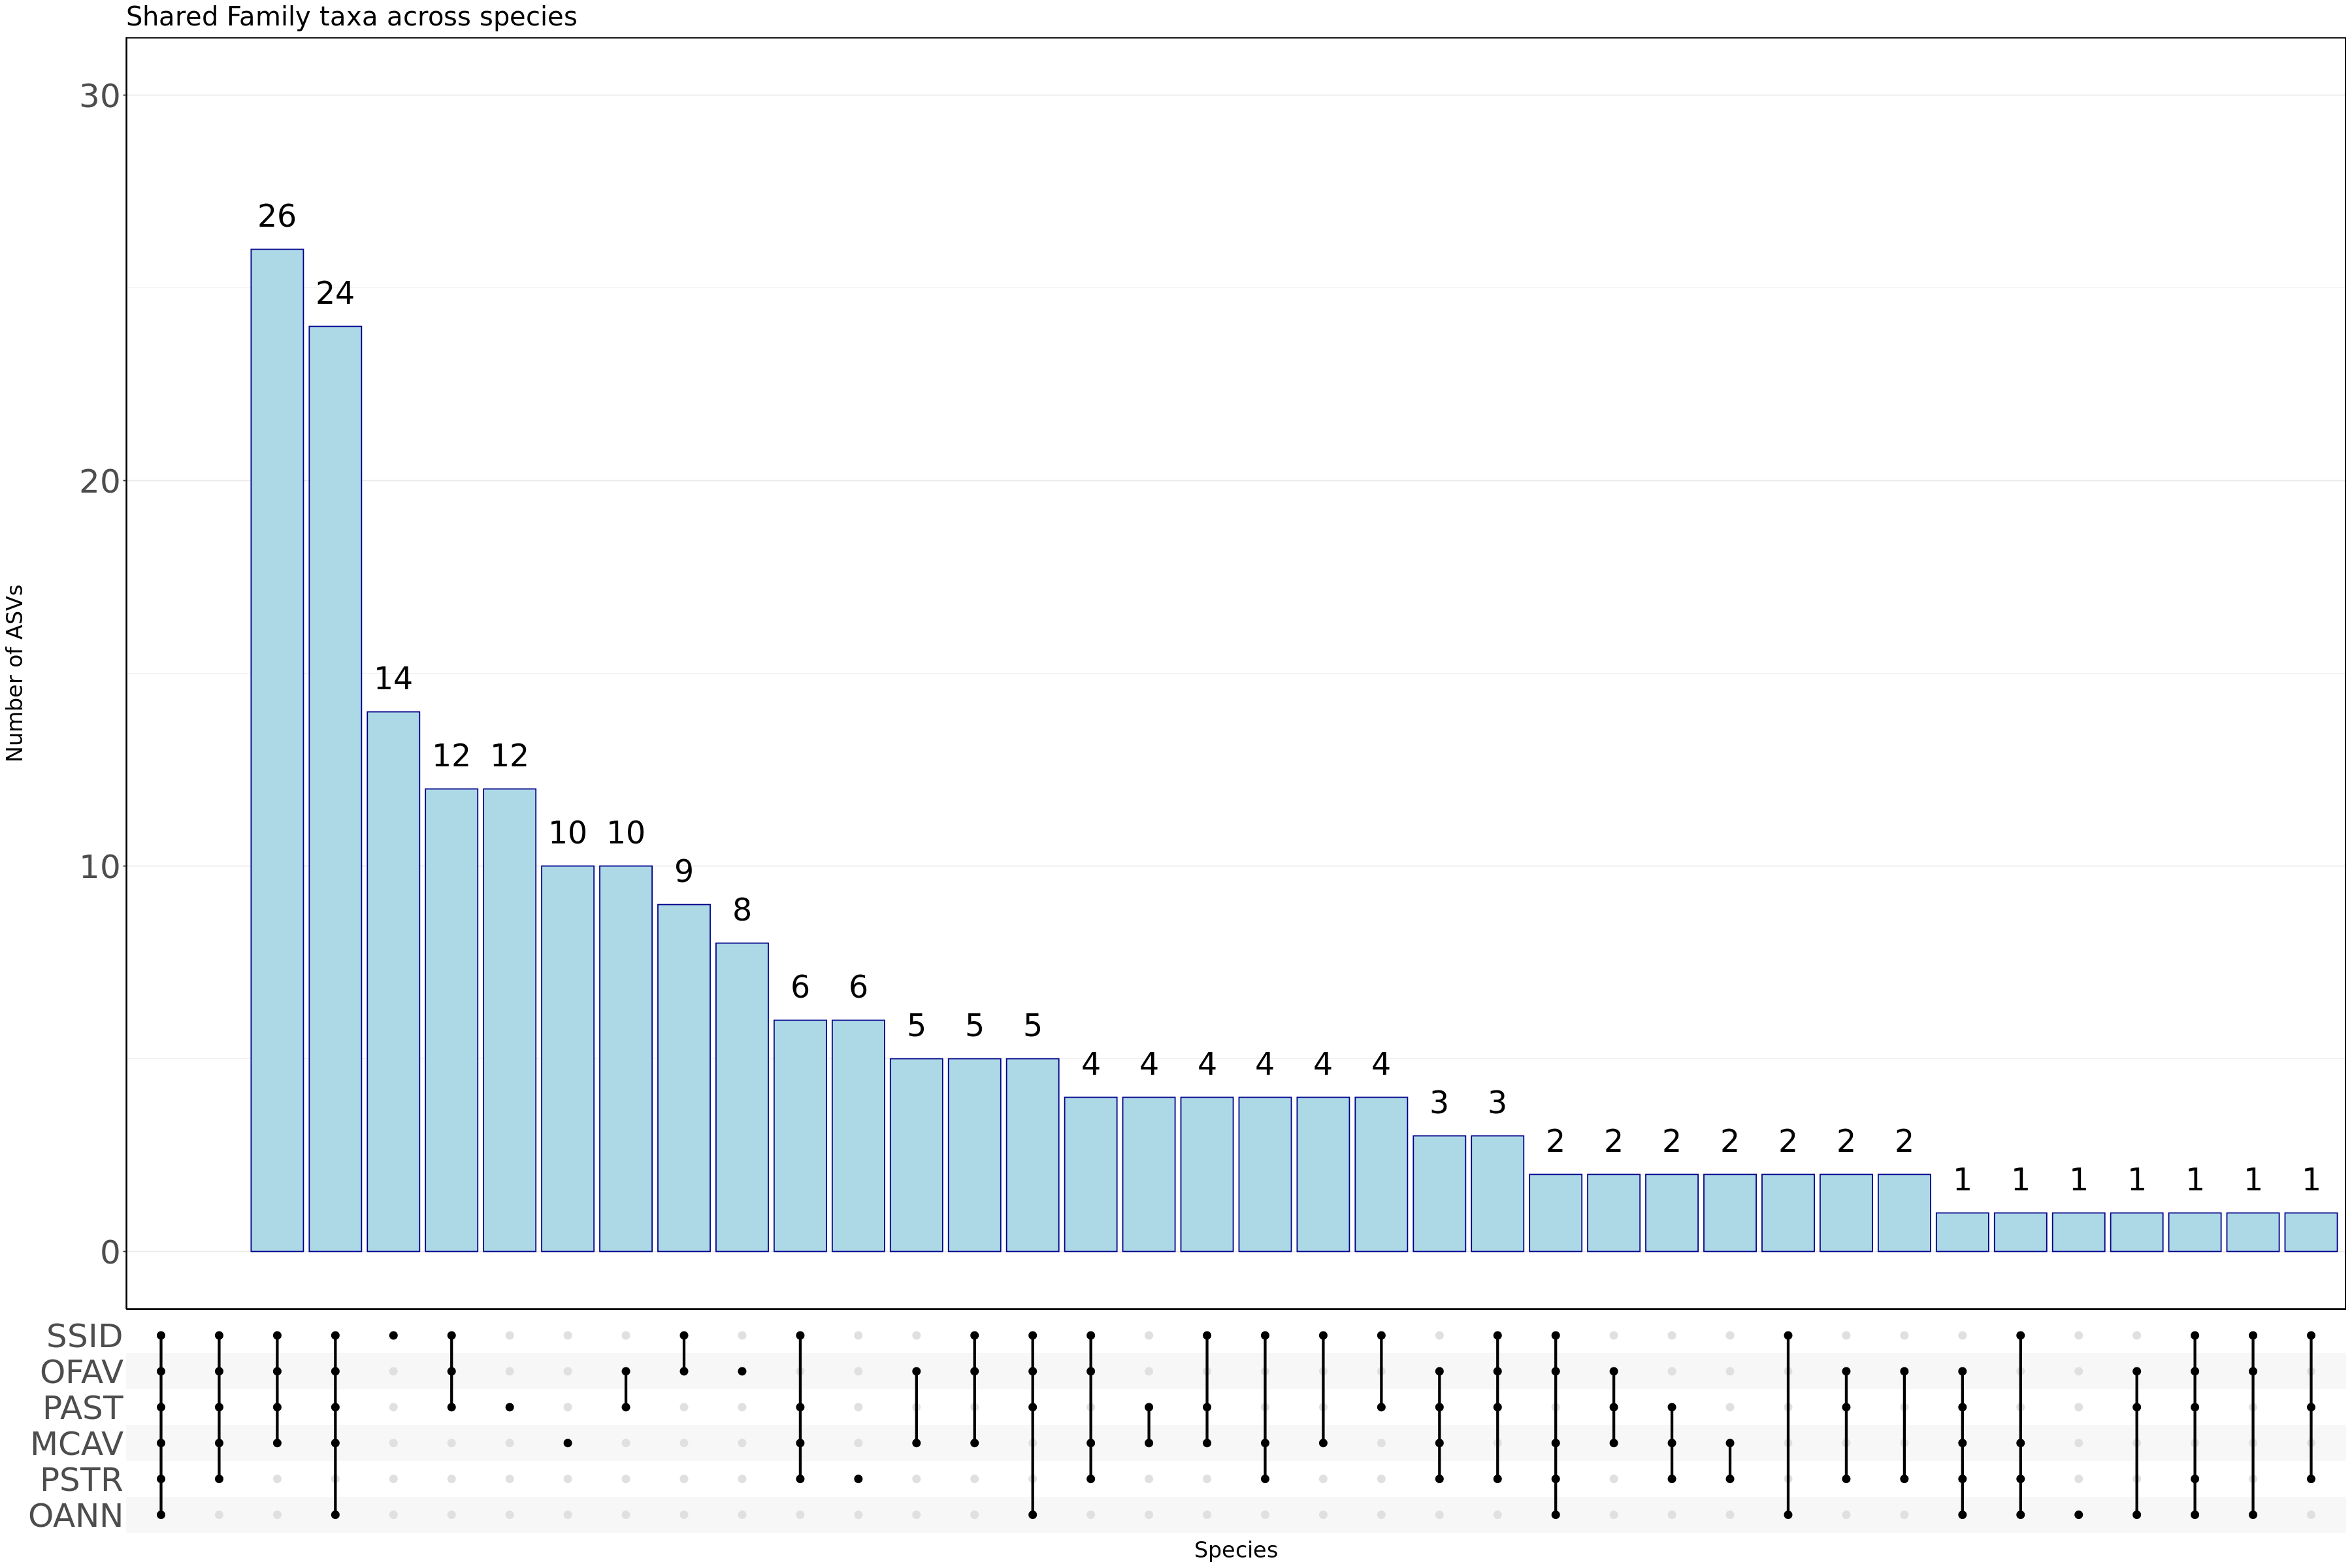

In [39]:
plot_spec_fam <- spec_fam%>%
ggplot(aes(x=combination)) +
    geom_bar(color="darkblue", fill="lightblue") +
    geom_text(stat='count', aes(label=after_stat(count)), vjust=-1, size = 10) +
    scale_x_upset() +
    scale_y_continuous(lim = c(0, 30)) +
labs(title = "Shared Family taxa across species",
       x = "Species",
       y = "Number of ASVs") +
theme_bw() +
  theme(
    legend.position = "right",
      legend.title = element_text(size = 20),
  legend.text = element_text(size = 15),
  legend.key.width = unit(1.3, "cm"),     # make the legend keys wider
  legend.key.height = unit(1.5, "cm"),   # make them taller
    panel.border = element_rect(color = "black", fill = NA, linewidth = 1),
    panel.grid.major.x = element_blank(),
    panel.grid.minor.x = element_blank(),
    axis.ticks.x = element_blank(),
    axis.line = element_line(color = "black"),
    axis.text.x = element_text(angle = 90, vjust = 1, hjust = 1, size=30),
    axis.text.y = element_text(size = 30),
    text = element_text(size = 20)
  )
plot_spec_fam

In [40]:
# Save the plot as a PNG
ggsave("/work/pi_sarah_gignouxwolfsohn_uml_edu/caroline/BEL_16S_outputs/plots/species_fam_upset.png", plot = plot_spec_fam, width = 30, height = 20, units = "in", dpi = 300)

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_text()`).”


## Month year:Family

In [41]:
monyr_fam <- compare_all %>%
  filter(Family %in% top500_fam) %>%
  select(MonthYear, Family, PA) %>%
  group_by(MonthYear, Family) %>%
  summarise(PA = any(PA), .groups = "drop") %>%
  pivot_wider(
    names_from = Family,
    values_from = PA,
    values_fill = FALSE
  )

head(monyr_fam)

MonthYear,01D2Z36,37-13,4572-13,67-14,A4b,AB-539-J10,AB1,AEGEAN-169 marine group,AKAU3564 sediment group,⋯,WWH38,Waddliaceae,Weeksellaceae,Woeseiaceae,Xanthobacteraceae,Xenococcaceae,Xiphinematobacteraceae,cvE6,env.OPS 17,koll11
<fct>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,⋯,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>
Jun 2019,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,⋯,FALSE,FALSE,FALSE,TRUE,TRUE,TRUE,FALSE,FALSE,FALSE,FALSE
May 2022,TRUE,FALSE,TRUE,FALSE,TRUE,FALSE,TRUE,TRUE,TRUE,⋯,FALSE,FALSE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,FALSE,TRUE
Dec 2022,TRUE,TRUE,TRUE,FALSE,TRUE,FALSE,TRUE,TRUE,TRUE,⋯,FALSE,FALSE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE
Sep 2023,TRUE,TRUE,FALSE,TRUE,TRUE,FALSE,TRUE,TRUE,TRUE,⋯,FALSE,TRUE,TRUE,TRUE,TRUE,TRUE,FALSE,TRUE,TRUE,TRUE
Nov 2023,FALSE,FALSE,TRUE,TRUE,TRUE,FALSE,TRUE,TRUE,TRUE,⋯,FALSE,FALSE,TRUE,TRUE,TRUE,TRUE,FALSE,TRUE,FALSE,TRUE
Dec 2023,TRUE,TRUE,TRUE,TRUE,TRUE,FALSE,TRUE,TRUE,TRUE,⋯,FALSE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,FALSE,TRUE


In [42]:
# Move the first column to row names
my_fam <- monyr_fam %>%
  tibble::column_to_rownames(var = colnames(monyr_fam)[1])
# Transpose the matrix/data frame to make columns easier to separate
monyr_fam <- t(my_fam)
#make it a dataframe
monyr_fam <- as.data.frame(monyr_fam)
head(monyr_fam)

,Jun 2019,May 2022,Dec 2022,Sep 2023,Nov 2023,Dec 2023,Jan 2024,Feb 2024,Apr 2024,Jun 2024,Aug 2024
,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>
01D2Z36,FALSE,TRUE,TRUE,TRUE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,TRUE
37-13,FALSE,FALSE,TRUE,TRUE,FALSE,TRUE,TRUE,FALSE,TRUE,FALSE,TRUE
4572-13,FALSE,TRUE,TRUE,FALSE,TRUE,TRUE,FALSE,FALSE,FALSE,TRUE,TRUE
67-14,FALSE,FALSE,FALSE,TRUE,TRUE,TRUE,TRUE,FALSE,TRUE,TRUE,TRUE
A4b,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE
AB-539-J10,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE


In [43]:
##create a combination column
monyr <- c("Jun 2019", "May 2022", "Dec 2022", "Sep 2023", "Nov 2023", "Dec 2023", "Jan 2024", "Feb 2024", "Apr 2024", "Jun 2024", "Aug 2024")

monyr_fam <- monyr_fam %>%
  mutate(combination = pmap(
    pick(all_of(monyr)),
    \(...) monyr[c(...)]
  ))

In [44]:
head(monyr_fam)

,Jun 2019,May 2022,Dec 2022,Sep 2023,Nov 2023,Dec 2023,Jan 2024,Feb 2024,Apr 2024,Jun 2024,Aug 2024,combination
,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<list>
01D2Z36,FALSE,TRUE,TRUE,TRUE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,TRUE,May 2022....
37-13,FALSE,FALSE,TRUE,TRUE,FALSE,TRUE,TRUE,FALSE,TRUE,FALSE,TRUE,Dec 2022....
4572-13,FALSE,TRUE,TRUE,FALSE,TRUE,TRUE,FALSE,FALSE,FALSE,TRUE,TRUE,May 2022....
67-14,FALSE,FALSE,FALSE,TRUE,TRUE,TRUE,TRUE,FALSE,TRUE,TRUE,TRUE,Sep 2023....
A4b,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,Jun 2019....
AB-539-J10,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,Jan 2024


In [45]:
#make this plot much wider 
options(repr.plot.width=45, repr.plot.height=30)

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_text()`).”


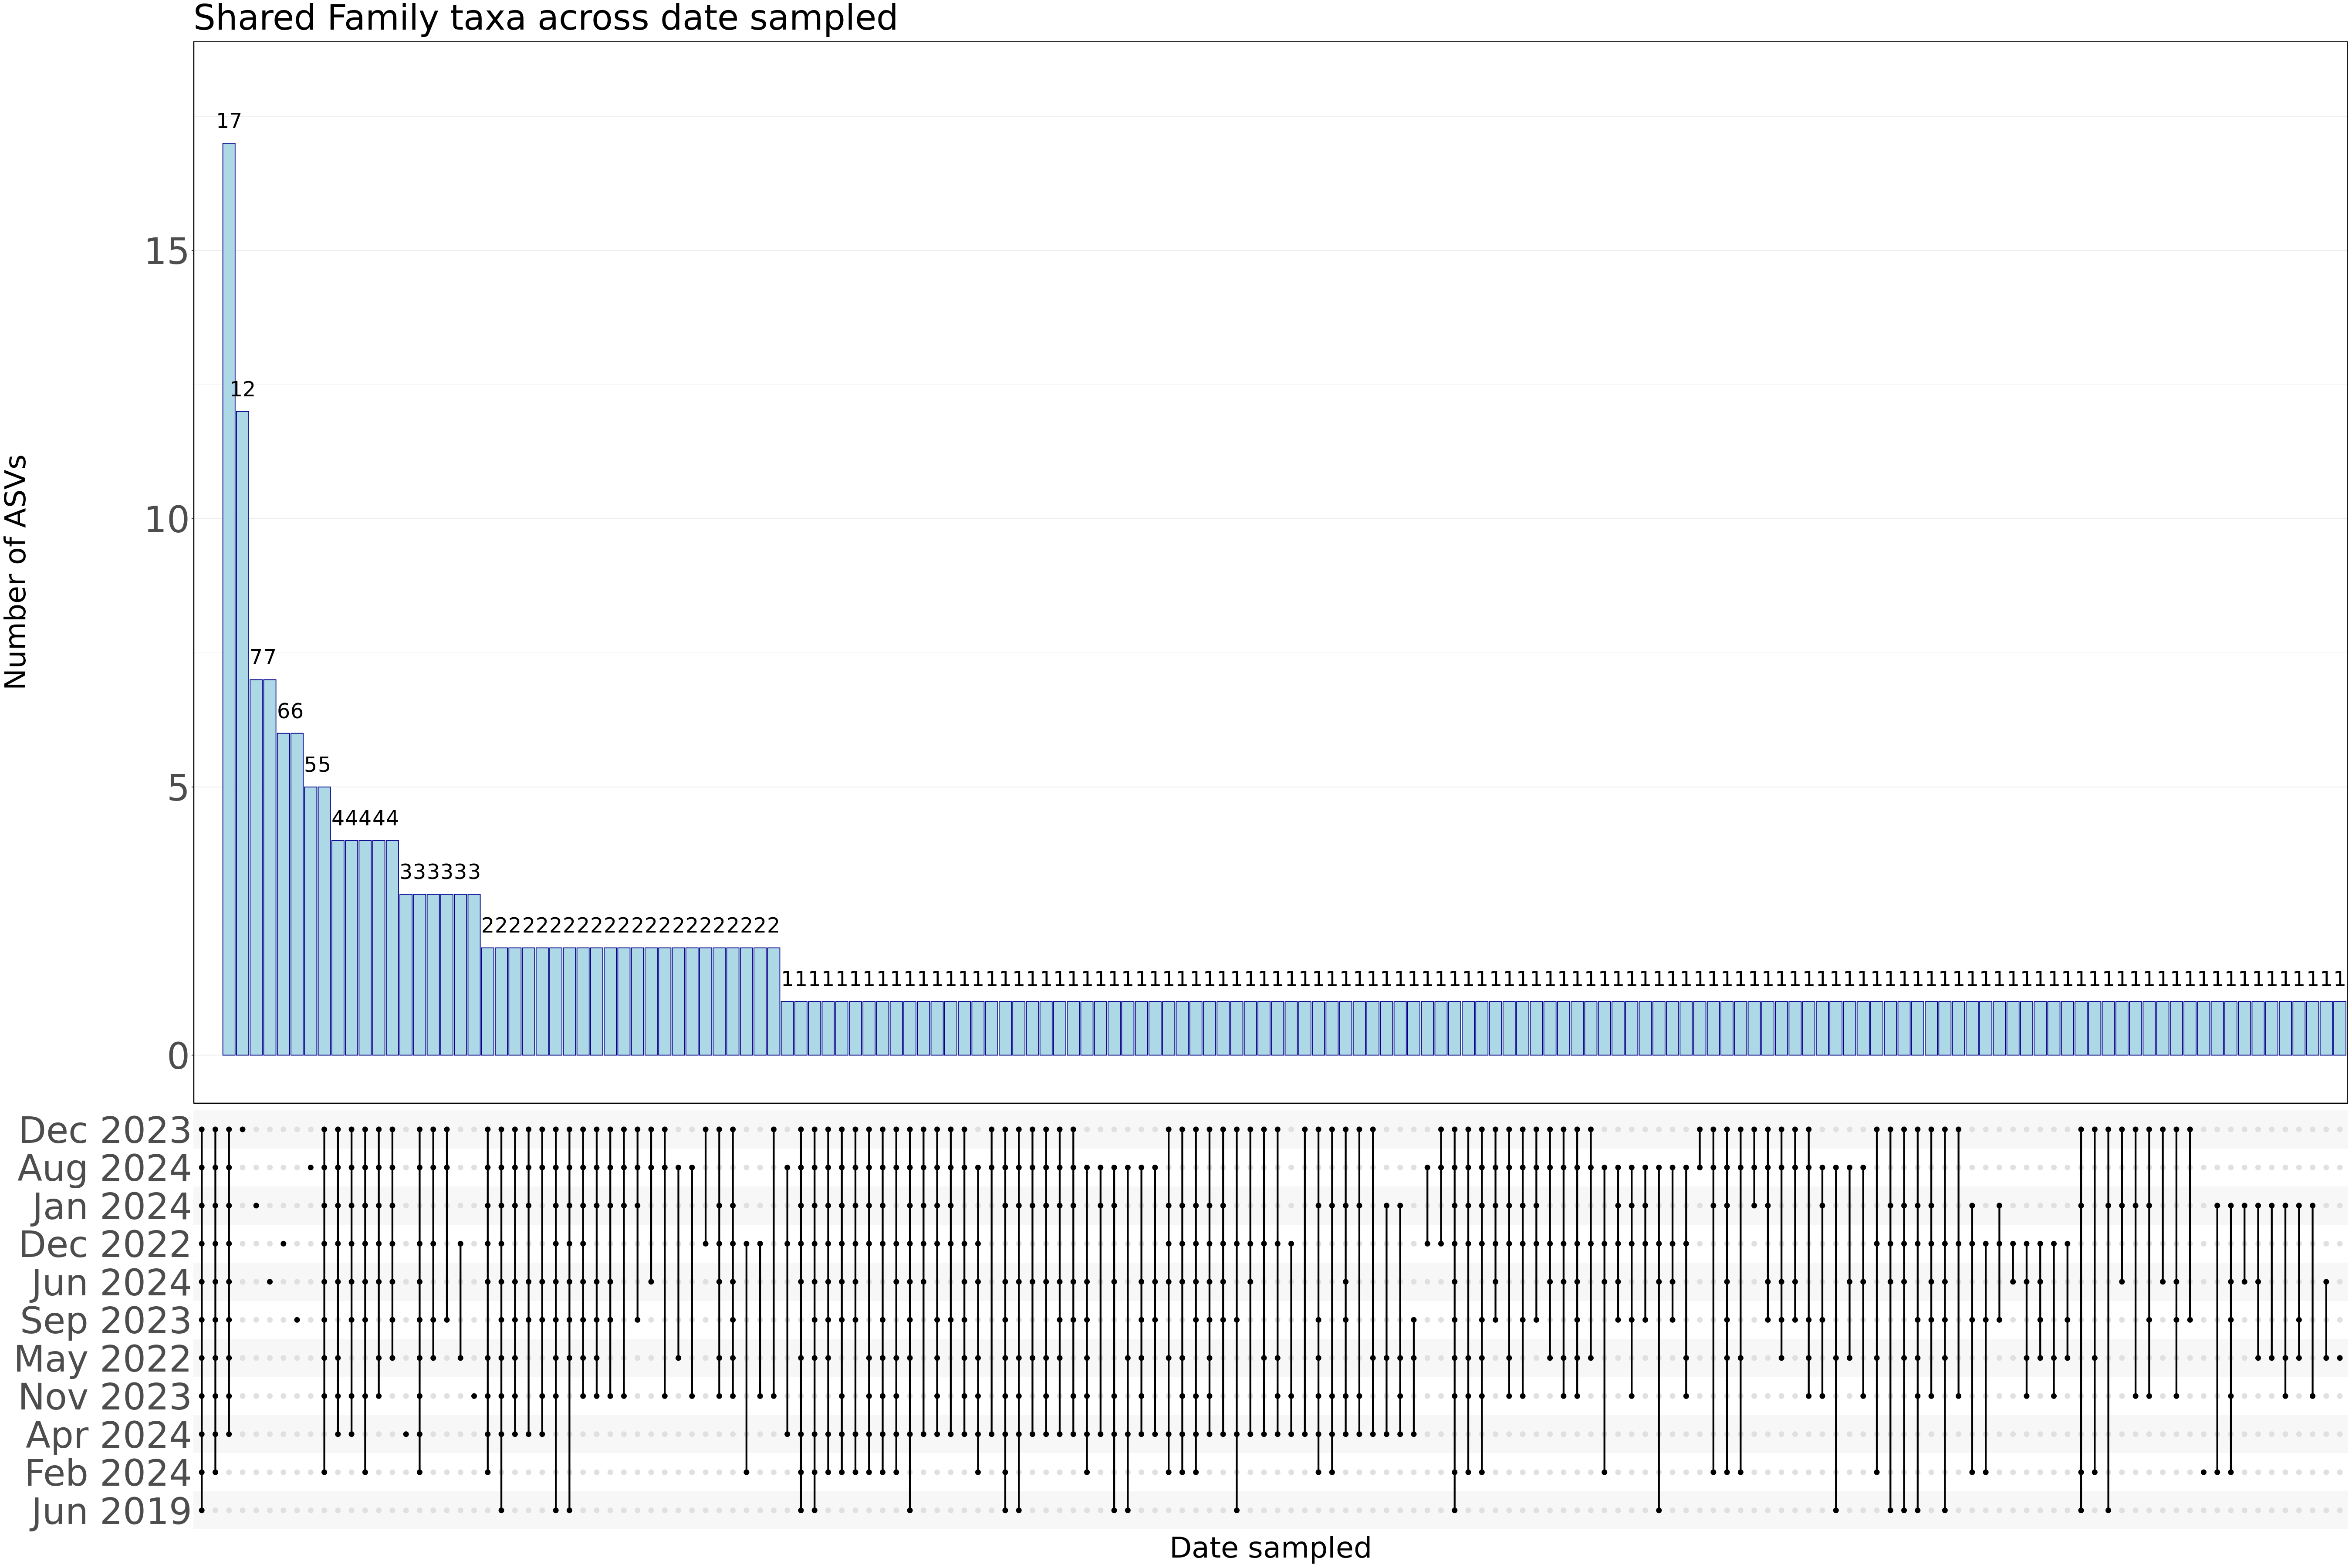

In [46]:
plot_monyr_fam <- monyr_fam%>%
ggplot(aes(x=combination)) +
    geom_bar(color="darkblue", fill="lightblue") +
    geom_text(stat='count', aes(label=after_stat(count)), vjust=-1, size = 10) +
    scale_x_upset() +
    scale_y_continuous(lim = c(0, 18)) +
labs(title = "Shared Family taxa across date sampled",
       x = "Date sampled",
       y = "Number of ASVs") +
theme_bw() +
  theme(
    legend.position = "right",
      legend.title = element_text(size = 20),
  legend.text = element_text(size = 15),
  legend.key.width = unit(1.3, "cm"),     # make the legend keys wider
  legend.key.height = unit(1.5, "cm"),   # make them taller
    panel.border = element_rect(color = "black", fill = NA, linewidth = 1),
    panel.grid.major.x = element_blank(),
    panel.grid.minor.x = element_blank(),
    axis.ticks.x = element_blank(),
    axis.line = element_line(color = "black"),
    axis.text.x = element_text(angle = 90, vjust = 1, hjust = 1, size=50),
    axis.text.y = element_text(size = 50),
    text = element_text(size = 40)
  )
plot_monyr_fam

In [48]:
# Save the plot as a PNG
ggsave("/work/pi_sarah_gignouxwolfsohn_uml_edu/caroline/BEL_16S_outputs/plots/monthyear_fam_upset.png", plot = plot_monyr_fam, width = 45, height = 30, units = "in", dpi = 300)

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_text()`).”


## COndition:family 

In [90]:
con_fam <- compare_all %>%
  filter(Family %in% top500_fam) %>%
  select(Condition, Family, PA) %>%
  group_by(Condition, Family) %>%
  summarise(PA = any(PA), .groups = "drop") %>%
  pivot_wider(
    names_from = Family,
    values_from = PA,
    values_fill = FALSE
  )

head(con_fam)

Condition,01D2Z36,37-13,4572-13,67-14,A4b,AB-539-J10,AB1,AEGEAN-169 marine group,AKAU3564 sediment group,⋯,WWH38,Waddliaceae,Weeksellaceae,Woeseiaceae,Xanthobacteraceae,Xenococcaceae,Xiphinematobacteraceae,cvE6,env.OPS 17,koll11
<chr>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,⋯,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>
CLB,TRUE,FALSE,TRUE,FALSE,TRUE,FALSE,TRUE,TRUE,TRUE,⋯,FALSE,TRUE,TRUE,TRUE,TRUE,TRUE,FALSE,TRUE,FALSE,TRUE
"CLB,CLP",TRUE,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE,TRUE,TRUE,⋯,FALSE,FALSE,FALSE,TRUE,TRUE,TRUE,TRUE,FALSE,FALSE,TRUE
CLP,FALSE,TRUE,FALSE,TRUE,TRUE,FALSE,TRUE,TRUE,TRUE,⋯,FALSE,FALSE,TRUE,TRUE,TRUE,TRUE,FALSE,FALSE,FALSE,TRUE
"CLP,CLB",FALSE,FALSE,FALSE,TRUE,TRUE,FALSE,TRUE,TRUE,FALSE,⋯,FALSE,FALSE,TRUE,TRUE,TRUE,TRUE,FALSE,TRUE,FALSE,TRUE
DC,FALSE,FALSE,FALSE,TRUE,TRUE,FALSE,TRUE,TRUE,TRUE,⋯,FALSE,FALSE,TRUE,TRUE,TRUE,TRUE,FALSE,TRUE,FALSE,TRUE
Diseased,FALSE,FALSE,TRUE,FALSE,TRUE,FALSE,FALSE,TRUE,FALSE,⋯,FALSE,FALSE,TRUE,TRUE,TRUE,TRUE,FALSE,FALSE,FALSE,FALSE


In [91]:
# Move the first column to row names
c_fam <- con_fam %>%
  tibble::column_to_rownames(var = colnames(con_fam)[1])
# Transpose the matrix/data frame to make columns easier to separate
con_fam <- t(c_fam)
#make it a dataframe
con_fam <- as.data.frame(con_fam)
head(con_fam)

,CLB,"CLB,CLP",CLP,"CLP,CLB",DC,Diseased,Diseased_Other,"Diseased_Other, CLP",Healthy
,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>
01D2Z36,TRUE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE
37-13,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE
4572-13,TRUE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE,TRUE
67-14,FALSE,FALSE,TRUE,TRUE,TRUE,FALSE,FALSE,FALSE,TRUE
A4b,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE
AB-539-J10,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE


In [96]:
##create a combination column
condition <- c("CLB", "CLB,CLP", "CLP", "CLP,CLB", "DC", "Diseased", "Diseased_Other", "Diseased_Other, CLP", "Healthy")

con_fam <- con_fam %>%
  mutate(combination = pmap(
    pick(all_of(condition)),
    \(...) condition[c(...)]
  ))

In [ ]:
#make this plot much wider 
options(repr.plot.width=30, repr.plot.height=20)

Warning message:
“Removed 7 rows containing missing values or values outside the scale range
(`geom_bar()`).”
Warning message:
“Removed 7 rows containing missing values or values outside the scale range
(`geom_text()`).”


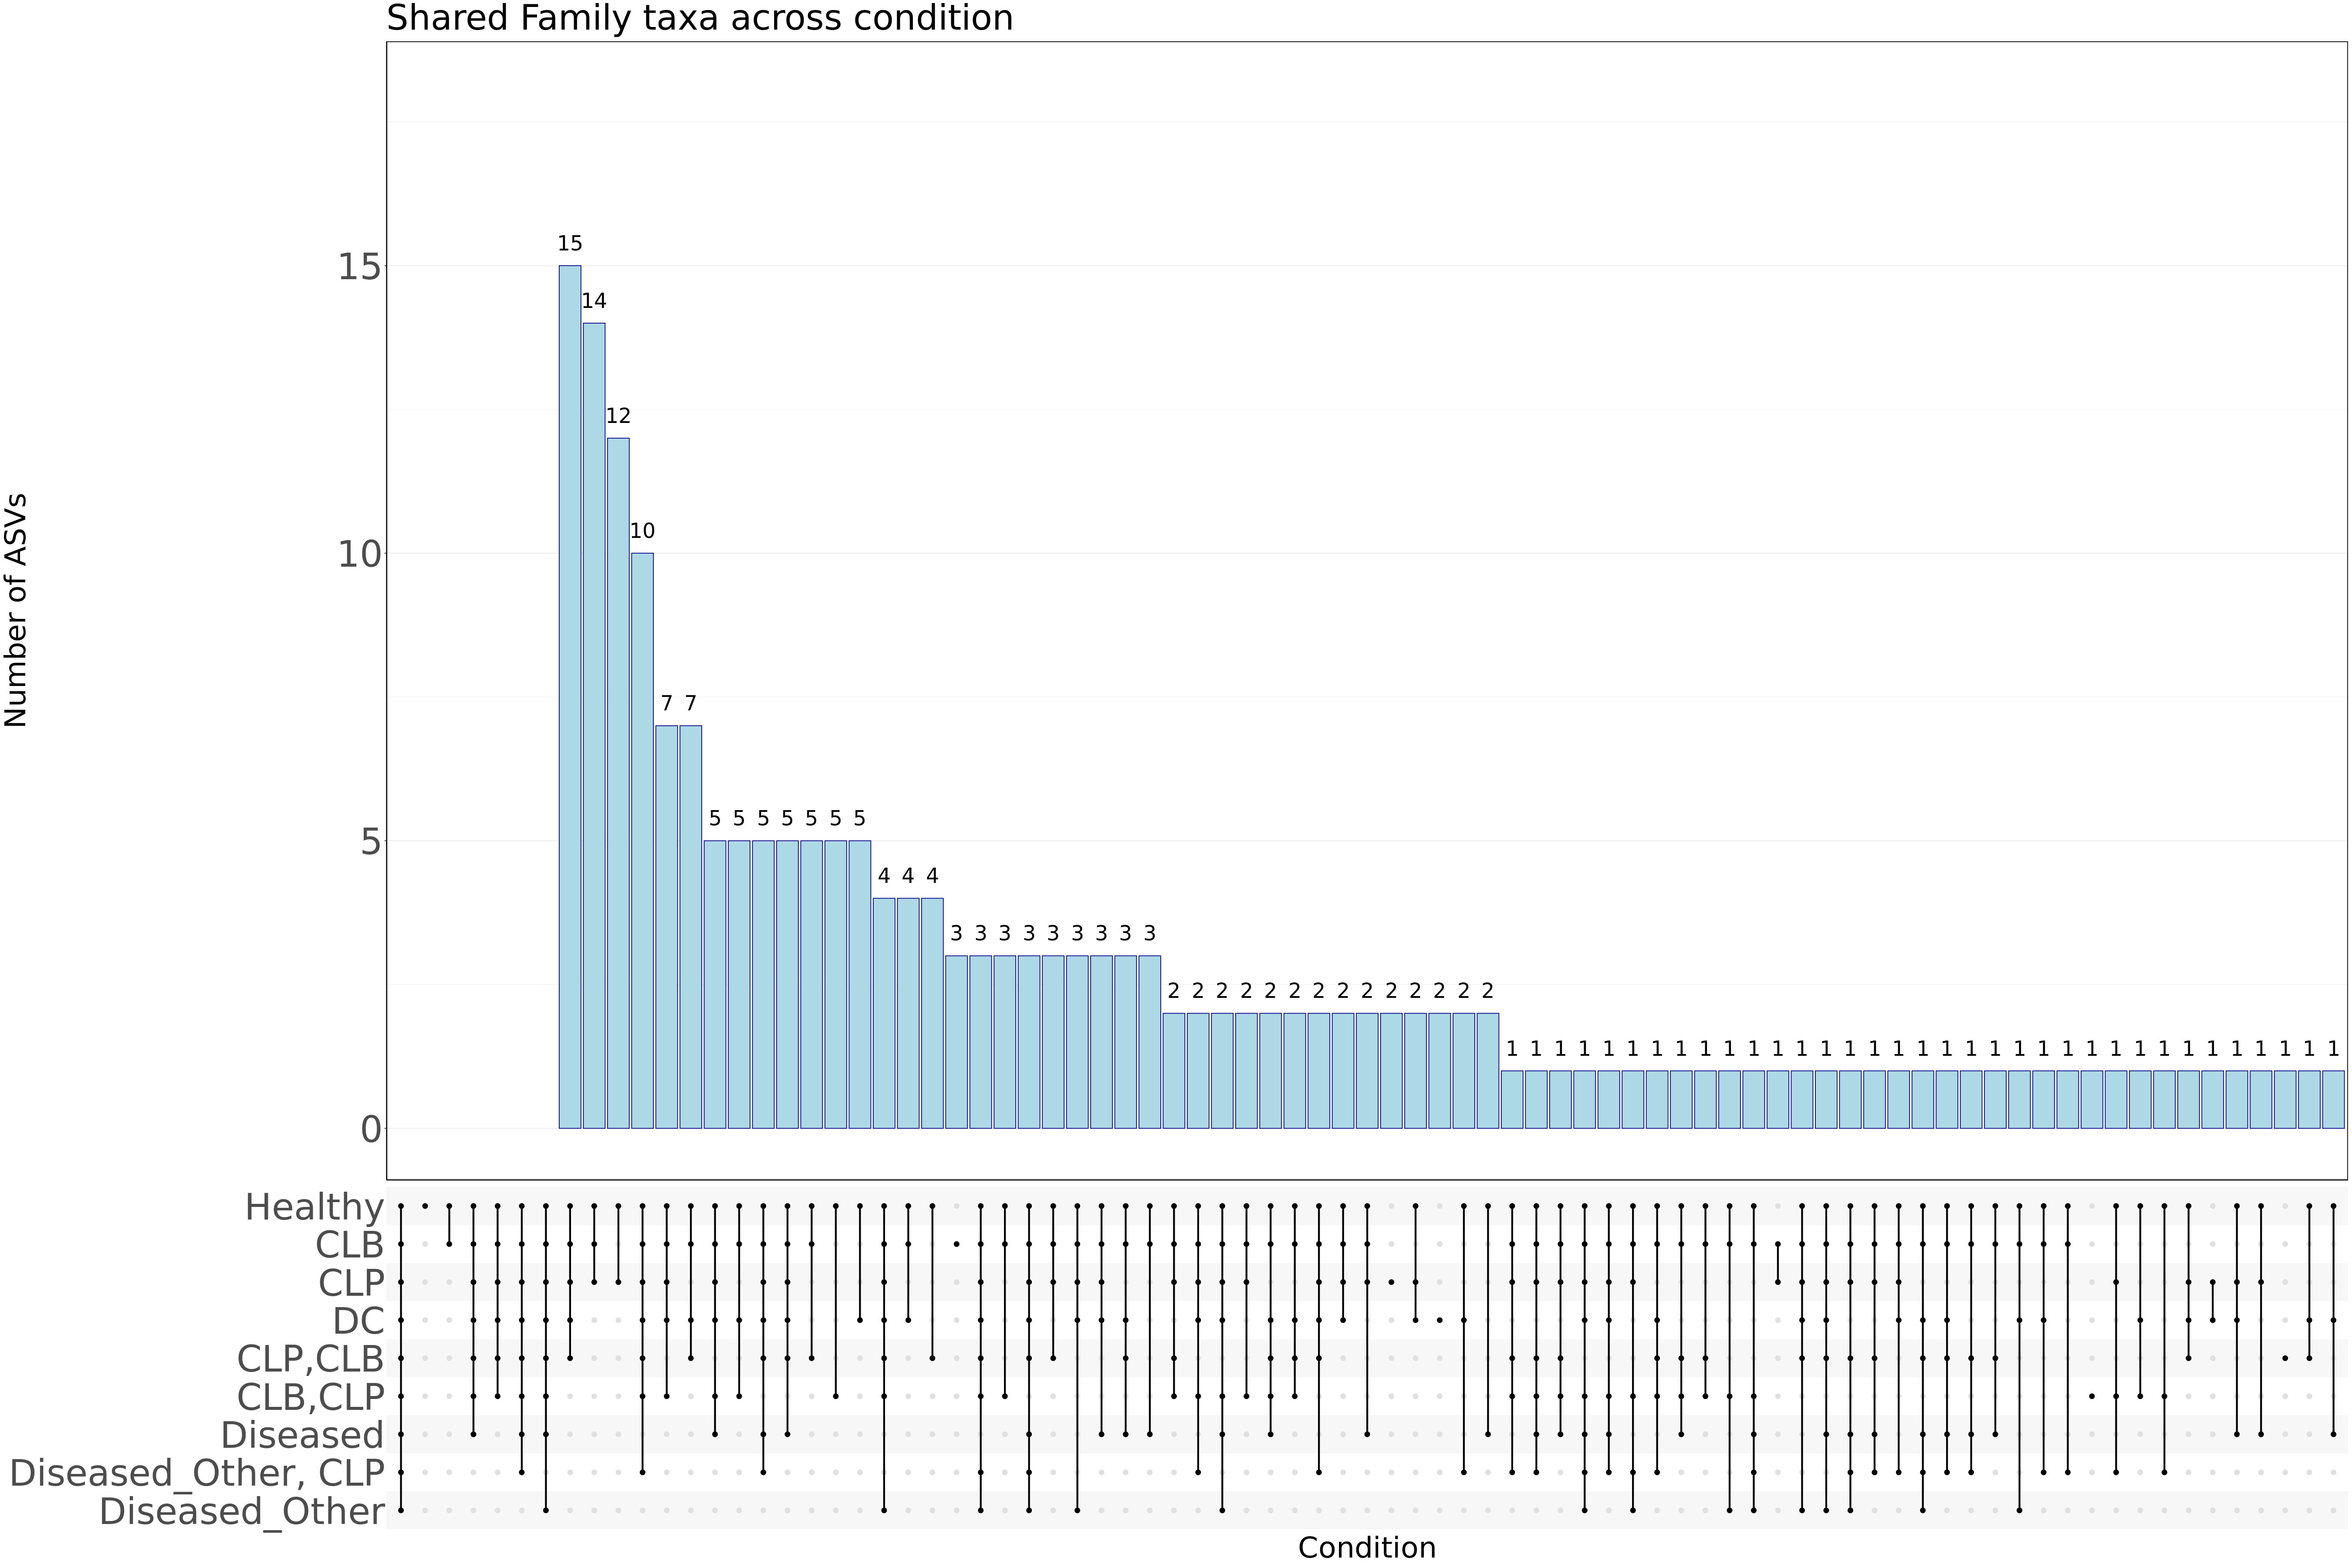

In [97]:
plot_con_fam <- con_fam%>%
ggplot(aes(x=combination)) +
    geom_bar(color="darkblue", fill="lightblue") +
    geom_text(stat='count', aes(label=after_stat(count)), vjust=-1, size = 10) +
    scale_x_upset() +
    scale_y_continuous(lim = c(0, 18)) +
labs(title = "Shared Family taxa across condition",
       x = "Condition",
       y = "Number of ASVs") +
theme_bw() +
  theme(
    legend.position = "right",
      legend.title = element_text(size = 20),
  legend.text = element_text(size = 15),
  legend.key.width = unit(1.3, "cm"),     # make the legend keys wider
  legend.key.height = unit(1.5, "cm"),   # make them taller
    panel.border = element_rect(color = "black", fill = NA, linewidth = 1),
    panel.grid.major.x = element_blank(),
    panel.grid.minor.x = element_blank(),
    axis.ticks.x = element_blank(),
    axis.line = element_line(color = "black"),
    axis.text.x = element_text(angle = 90, vjust = 1, hjust = 1, size=50),
    axis.text.y = element_text(size = 50),
    text = element_text(size = 40)
  )
plot_con_fam

## what are the most abundant otus across date_sampled?
- use heatmap to figure that out girl!

## heatmaps, find heatmap in vegan cluster notebook

In [90]:
library(ComplexHeatmap)
mat <- ps_long %>%
  select(OTU, Sample, PA) %>%
  mutate(PA = as.logical(PA)) %>%     # convert TRUE/FALSE
  tidyr::pivot_wider(
    names_from = Sample,
    values_from = PA,
    values_fill = list(PA = FALSE)    # fill missing with FALSE
  )

# Convert to base R matrix
rownames_vec <- mat$OTU
mat <- as.matrix(mat[,-1])
rownames(mat) <- rownames_vec
# Ensure matrix is logical
storage.mode(mat) <- "logical"

# Now call UpSet
UpSet(mat, set_on_rows = FALSE)

## old stuff from youtube

In [ ]:
#make combination column a variable instead of just a chr
#counts of all the combos of different subjects
compare_class <- compare_class %>%
mutate(
    combination = pmap_chr(
        list(MCAV, OANN, OFAV, PAST, PSTR, SSID), 
         \(lg1, lg2, lg3, lg4, lg5, lg6) {
         c('MCAV', 'OANN', 'OFAV', 'PAST', 'PSTR', 'SSID')[c(lg1, lg2, lg3, lg4, lg5, lg6)]}%>%
               paste0(collapse = ',') 
            )
        )%>%
count(combination) %>%
mutate(
    combination = fct_reorder(combination, n, .desc = TRUE
    )

In [ ]:
#counts for the individual subjects
ps_t %>%
    pivot_longer(
        cols = species
        values_to = "


In [109]:
# Plot
upset(ps_wide, 
      nintersects = NA, # number of interactions to plot, set to NA if intersections should be plotted
      nsets = 6, #number of sets to look at (in case of species 6)
      order.by = "freq", #how the intersections in the matrix should be ordered, options include freq and degress
      decreasing = T, # ordered in decreasing frequency of asv
      mb.ratio = c(0.6, 0.4), #ratio bw matrix plot and histogram
      number.angles = 0, 
      text.scale = 1.1, 
      point.size = 2.8, 
      line.size = 1,
      mainbar.y.label = "ASV interactions", sets.x.label = "Samples per Species",
      )

ERROR: Error in upset_data(data, intersect, mode = mode, encode_sets = encode_sets, : unused arguments (nintersects = NA, nsets = 6, order.by = "freq", decreasing = TRUE, mb.ratio = c(0.6, 0.4), number.angles = 0, text.scale = 1.1, point.size = 2.8, line.size = 1, mainbar.y.label = "ASV interactions", sets.x.label = "Samples per Species")
